In [9]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral
from ClassFiles.relion_fixed_it import load_star
from ClassFiles.AdversarialRegularizer import AdversarialRegulariser
from ClassFiles.ut import l2
from ClassFiles.Utilities import registration
from ClassFiles.ut import locate_gt, rfft, irfft, unify_form, Rescaler

In [10]:
NOISE_LEVEL = '01'
ITERATION = '01'
METHODE = 'EM'
PDB_ID = '5A0M'

In [11]:
base_path = '/local/scratch/public/sl767/MRC_Data/Data/Data_0{n}_10k/eval/{m}/{PDB}/'
path=base_path+'{PDB}_mult0{n}_it0{i}_half2_class001_external_reconstruct.star'
path = path.format(n=NOISE_LEVEL, m=METHODE, PDB = PDB_ID, i=ITERATION)

In [12]:
file=load_star(path)

In [13]:
saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/AllData/AllAugmentation'
regularizer = AdversarialRegulariser(saves_path)

INFO:tensorflow:Restoring parameters from /local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/AllData/AllAugmentation//Data/model-5000
Save restored


In [14]:
Registrator = registration.LocalRegistrator()

/alt/applic/user-maint/sl767/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [15]:
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
    data_real = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
    data_im = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
    kernel = mrc.data.copy()
with mrcfile.open(locate_gt(PDB_ID, full_path=False)) as mrc:
    ground_truth = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsResult']) as mrc:
    naive_recon = mrc.data.copy()
    
ground_truth = unify_form(ground_truth)
r_gt = Rescaler(ground_truth)
r_gt.normalize(ground_truth)

complex_data=data_real + 1j * data_im

In [18]:
def l2_gt(x):
    image=unify_form(np.copy(x))
    r=Rescaler(image)
    r.normalize(image)
    reg=Registrator.register(image=image, reference=ground_truth)
    return l2(reg-ground_truth)


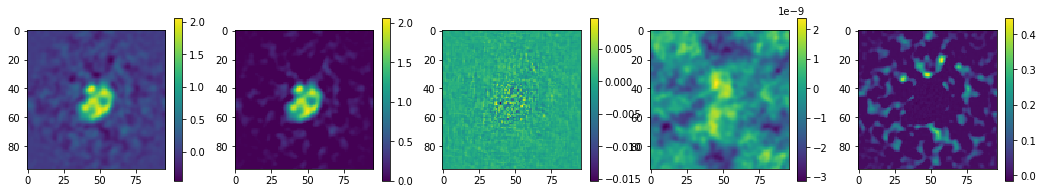

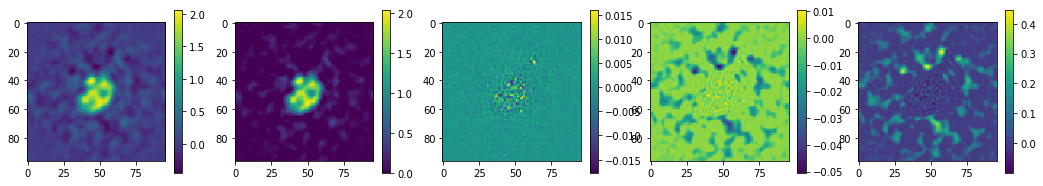

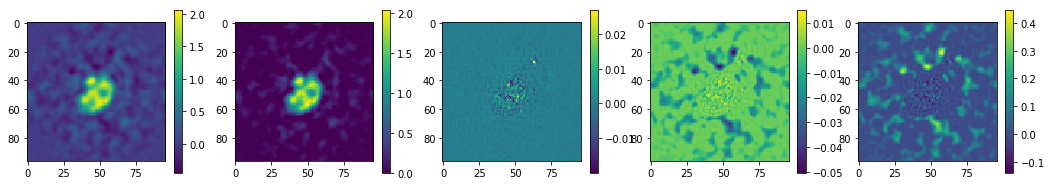

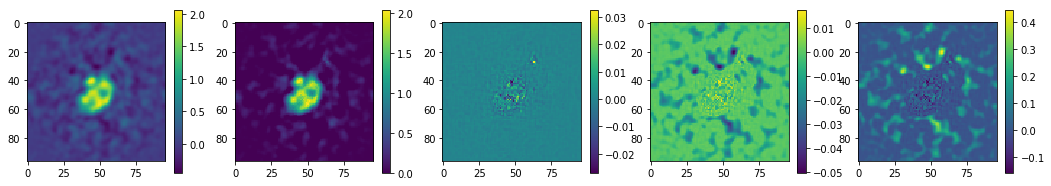

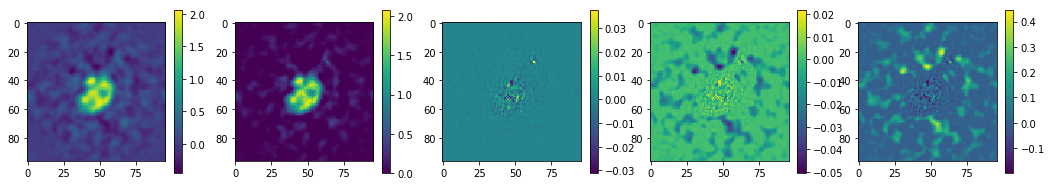

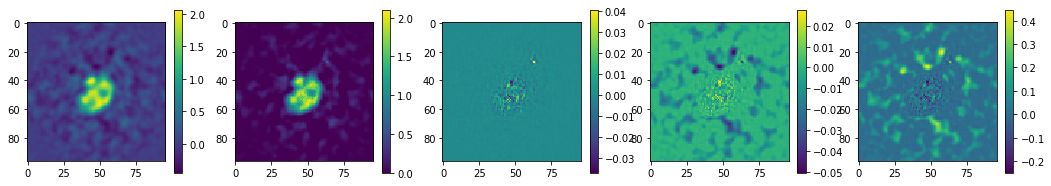

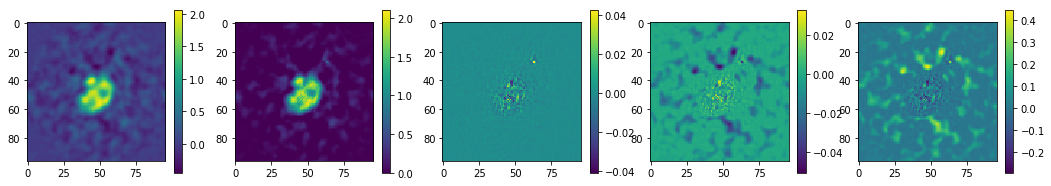

In [26]:
def vis(data, fourier=True):
    if fourier:
        data = irfft(data)
    plt.imshow(data.squeeze()[...,45])
#     plt.imshow(np.mean(data.squeeze(), axis=-1))

tikhonov_kernel = kernel + 1e6
precondioner = np.abs(np.divide(1, tikhonov_kernel))
precondioner /= precondioner.max()
tikhonov = np.divide(complex_data, tikhonov_kernel)
reco = np.copy(tikhonov)

# The scales produce gradients of order 1
ADVERSARIAL_SCALE=(96**(-0.5))
DATA_SCALE=1/(10*96**3)

IMAGING_SCALE=96

for k in range(70):
    STEP_SIZE=1.0 * 1 / np.sqrt(1 + k / 20)
    
    gradient = regularizer.evaluate(reco)
    g1 = 0.002 * gradient * ADVERSARIAL_SCALE
#     print(l2(gradient))
    g2 = DATA_SCALE*(np.multiply(reco, tikhonov_kernel) - complex_data)
    
    g = g1 + g2
#     reco = reco - STEP_SIZE * 0.02 * g
    reco = reco - STEP_SIZE * precondioner * g
    
    reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
        
    #reco = reco - STEP_SIZE*(g1 + g2 + g3)
    if k%10==0:
        plt.figure(k, figsize=(18,3))
        plt.subplot(151)
        vis(IMAGING_SCALE*tikhonov)
        plt.colorbar()
        plt.subplot(152)
        vis(IMAGING_SCALE*reco)
        plt.colorbar()
        plt.subplot(153)
        vis(-IMAGING_SCALE*precondioner*g1)
        plt.colorbar()
        plt.subplot(154)
        vis(-IMAGING_SCALE*precondioner*g2)
        plt.colorbar()
        plt.subplot(155)
        vis(IMAGING_SCALE*(reco - tikhonov))
        plt.colorbar()
        plt.show()